In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import math as math
from timeit import default_timer as timer
from tqdm import tqdm
import scipy.optimize
import copy

# Heisenberg Model

## Task 1
**Implement a Metropolis simulation of the 3D Heisenberg model**

In [6]:
"""
Args:
    x: Spin configuration
    i, j, k: Indices describing the position of one spin
Returns:
    sum of dot-product of spin ijk whith its nearest neighbors
"""
def nn_dot_3d(grid, i, j, k):

    L = np.size(grid,1)
    result = np.dot(grid[i,j,k,:],grid[(i-1)%L,j,k,:])+np.dot(grid[i,j,k,:],grid[(i+1)%L,j,k,:]) #left and rigth
    result += np.dot(grid[i,j,k,:],grid[i,(j+1)%L,k,:])+np.dot(grid[i,j,k,:],grid[i,(j-1)%L,k,:]) #top and bottom
    result += np.dot(grid[i,j,k,:],grid[i,j,(k-1)%L,:])+np.dot(grid[i,j,k,:],grid[i,j,(k+1)%L,:]) # front and back
    return int(result)


def total_energy_3d(grid):
    """
    Args:
        x: Spin configuration

    Returns:
        Total energy of configuration x.
    """
    L = np.size(grid,1)
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                # TODO: compute energy of site (i,j,k)
                energy -= nn_dot_3d(grid,i,j,k)/2
			
    return energy

def total_momentum_3d(grid):
    
    #L = np.size(grid,1)
    #N = L**3
    M = np.zeros((3))
    M[0] = np.sum(grid[:,:,:,0])
    M[1] = np.sum(grid[:,:,:,1])
    M[2] = np.sum(grid[:,:,:,2])
    return M
    


def move_3d(x, M, E, b):
    """
    Args:
        x: Spin configuration
        M: Magnetization of x
        E: Energy of x
        b: inverse temperature

    Returns:
        Updated x, M and E after one Monte Carlo move
    """

    #TODO: pick one site at random
    L = np.size(x,1)
    i, j, k = rd.randrange(L), rd.randrange(L), rd.randrange(L)
    delta_E = 2*nn_dot_3d(x,i,j,k)
    old_x = x[i,j,k,:].copy()
    x[i,j,k,:] = np.array((rd.uniform(-1,1),rd.uniform(-1,1),rd.uniform(-1,1)))
    x[i,j,k,:] /= np.linalg.norm(x[i,j,k,:])
    delta_E -= 2*nn_dot_3d(x,i,j,k)
    # TODO: Compute the Metropolis acceptance probability `R` and compare it to a random number in [0,1)
    if (rd.random() < math.exp(- delta_E * b)):
        E += delta_E
        M += x[i,j,k,:]-old_x
        M = total_momentum_3d(x)
    else:
        x[i,j,k,:] = old_x.copy()

    return x, M, E





In [7]:
def simulate_3d(L,beta,Nthermalization,Nsample,Nsubsweep):
    
    N = L**3

    M_arr = np.zeros_like(beta) # average magnetizations
    E_arr = np.zeros_like(beta) # average energies
    M_err = np.zeros_like(beta) # standard deviations of the magnetizations
    E_err = np.zeros_like(beta) # standard deviations of the energies
    chi_arr = np.zeros_like(beta) # magnetic susceptibilities
    cv_arr = np.zeros_like(beta) # heat capacities

    # calculate the relevant physical quantities for different temperatures
    for t in range(beta.size):
        print('Running for inverse temperature =', beta[t])

        # TODO: Generate a random initial configuration
        # TODO: compute its magnetisation and energy

        # random initial configuration
        #x = np.random.randint(2, size=(L, L, L))*2 - 1 
        #M = np.sum(x)
        #E = total_energy_3d(x)
        
        #initila configuration with all spis pointing up
        x = np.ones((L, L, L,3))/np.sqrt(3)
        M = np.array((1000,1000,1000))/np.sqrt(3)
        E = -3*N

        # TODO: run a thermalisation loop
        print("thermalization.......")
        for _ in tqdm(range(Nthermalization)):
            x, M, E = move_3d(x, M, E, beta[t])
            
        # measurement of M and E
        print("Sampling M and E ...")

        M_data = np.zeros(Nsample)
        E_data = np.zeros(Nsample)

        M_data[0] = np.linalg.norm(M)/N
        E_data[0] = np.abs(E)/N

        for n in tqdm(range(1, Nsample)):
            for _ in range(Nsubsweep):
                x, M, E = move_3d(x, M, E, beta[t])

            M_data[n] = np.linalg.norm(M)/N
            E_data[n] = np.abs(E)/N

        M_arr[t] = np.mean(M_data) # average magnetization
        E_arr[t] = np.mean(E_data) # average energy
        # TODO: use the fluctuation dissipation to compute the 
        # specific heat and susceptibility from the M and E data
        M_err[t] = np.var(M_data) # std. deviation of magnetization
        E_err[t] = np.var(E_data) # std. deviation of energy
        chi_arr[t] = M_err[t]**2*N*beta[t]
        cv_arr[t] = E_err[t]**2*(beta[t]**2)
        
    return M_arr, E_arr, M_err, E_err, chi_arr, cv_arr 


In [8]:
#measure and plot the energy E the magnetization M the susceptibility chi and the heat capacity cv at different temperatures T
L = 5 # linear size of the system
N = L**3
beta = np.linspace(0.2, 0.8, 10) # inverse temperatures
Nthermalization = int(10e5) # number of thermalization steps
Nsample = 5000 # number of samples
Nsubsweep = 3*N # number of subsweeps (3 is the safety factor)

M_arr, E_arr, M_err, E_err, chi_arr, cv_arr = simulate_3d(L,beta,Nthermalization,Nsample,Nsubsweep)

Running for inverse temperature = 0.2
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:21<00:00, 45954.77it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:40<00:00, 123.91it/s]


Running for inverse temperature = 0.2666666666666667
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:21<00:00, 47360.05it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:39<00:00, 127.22it/s]


Running for inverse temperature = 0.33333333333333337
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:20<00:00, 48735.40it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:38<00:00, 130.35it/s]


Running for inverse temperature = 0.4
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:19<00:00, 51026.39it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:36<00:00, 136.14it/s]


Running for inverse temperature = 0.46666666666666673
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:18<00:00, 54849.17it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:33<00:00, 147.64it/s]


Running for inverse temperature = 0.5333333333333334
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:17<00:00, 57244.52it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:32<00:00, 154.38it/s]


Running for inverse temperature = 0.6000000000000001
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:16<00:00, 58899.32it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:31<00:00, 157.10it/s]


Running for inverse temperature = 0.6666666666666667
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:16<00:00, 59586.19it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:31<00:00, 159.39it/s]


Running for inverse temperature = 0.7333333333333334
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:16<00:00, 60087.04it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:31<00:00, 159.60it/s]


Running for inverse temperature = 0.8
thermalization.......


100%|██████████████████████████████| 1000000/1000000 [00:16<00:00, 60074.75it/s]


Sampling M and E ...


100%|██████████████████████████████████████| 4999/4999 [00:31<00:00, 160.83it/s]


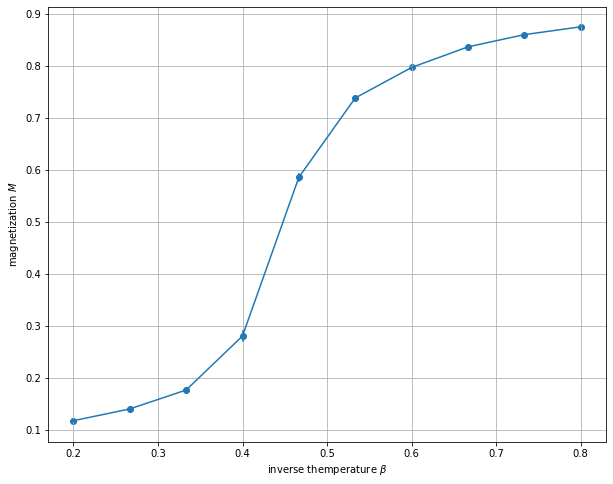

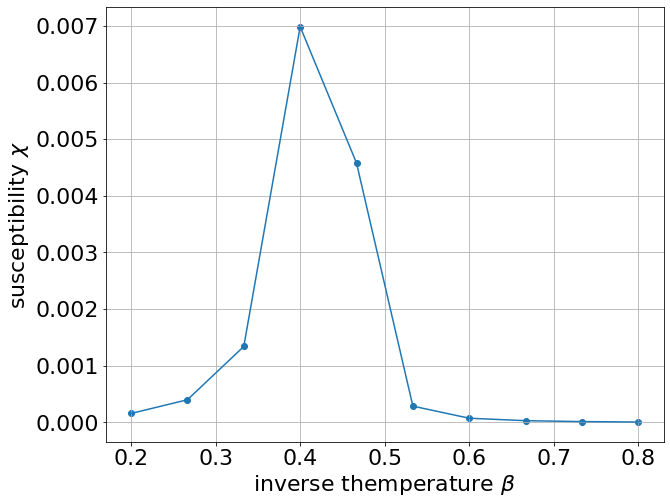

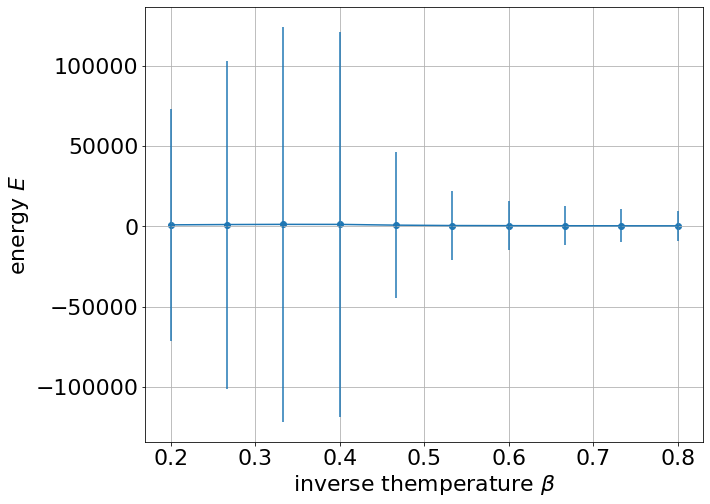

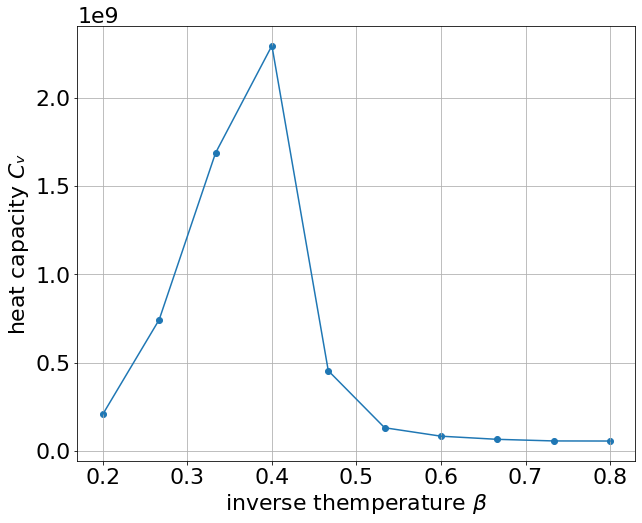

In [9]:
#plot magnetization
plt.figure(figsize=(10,8))
plt.scatter(beta, M_arr)
plt.errorbar(beta, M_arr,yerr = M_err)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"magnetization $M$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
plt.savefig("magnetization.svg", format = 'svg', dpi=300)

#plot susceptibility
plt.figure(figsize=(10,8))
plt.scatter(beta,chi_arr)
plt.plot(beta,chi_arr)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"susceptibility $\chi$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
plt.savefig("susceptibility.svg", format = 'svg', dpi=300)

#plot energy
plt.figure(figsize=(10,8))
plt.scatter(beta, E_arr)
plt.errorbar(beta, E_arr, yerr = E_err)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"energy $E$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
plt.savefig("energy.svg", format = 'svg', dpi=300)

#plot heat capacity
plt.figure(figsize=(10,8))
plt.scatter(beta,cv_arr)
plt.plot(beta,cv_arr)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"heat capacity $Cᵥ$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
plt.savefig("capacity.svg", format = 'svg', dpi=300)

## Task 2
**generalize the wolff algortihm for any number of spin components**

In [ ]:
#first implement the wolff algortihm